In [1]:
import numpy as np
from scipy.sparse import csr_matrix
#import assembler
from io import StringIO
from scipy.io import mmread
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import gmres
from scipy.sparse.linalg import lgmres
from scipy.sparse.linalg import cg
from scipy.sparse.linalg import minres
import scipy
from numpy.linalg import solve
from matplotlib import pyplot as plt
from scipy.sparse.linalg import LinearOperator, spilu
from scipy.sparse.linalg import inv
from scipy.sparse.linalg import bicgstab
import krypy
import csv
import time
from skfem import *
from skfem.models.poisson import unit_load

In [2]:
Problem='Wave'

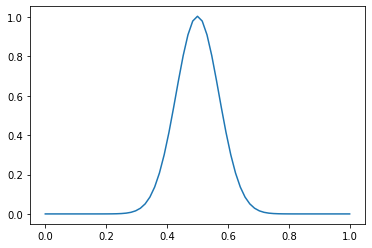

In [3]:
"""Wave equation."""
import numpy as np
from scipy.sparse import bmat, identity
from scipy.sparse.linalg import splu
from skfem import *
from skfem.models import laplace, mass


m = MeshLine().refined(6)
basis = Basis(m, ElementLineP1())

N = basis.N
L = laplace.assemble(basis)
M = mass.assemble(basis)
I = identity(N)
c = 1.

# reduction to first order system in time
A0 = bmat([[I, None],
           [None, M]], "csc")

B0 = bmat([[None, I],
           [-c ** 2 * L, None]], "csc")

# Crank-Nicolson
dt = .01
theta = .5
A = A0 + theta * B0 * dt
B = A0 - (1. - theta) * B0 * dt
backsolve = splu(A).solve
#print(backsolve)
#print('A',A)
# timestepping
def evolve(t, u):
    while t < 1:
        t = t + dt
        #print('B',B)
        u = backsolve(B @ u)
        #print('u',u)
        yield t, u

# initial conditions
def bump(x):
    return np.exp(-100. * (x[0] - .5) ** 2)


U0 = basis.project(bump)
U = np.concatenate((U0, np.zeros(N)))


if __name__ == "__main__":
    from pathlib import Path
    import matplotlib.pyplot as plt
    import matplotlib.animation as anim

    fig, ax = plt.subplots()
    ix = np.argsort(m.p[0])
    line, = ax.plot(m.p[0, ix], U0[ix])

    def update(t_u):
        t, u = t_u
        u1, _ = np.split(u, [M.shape[0]])
        line.set_ydata(u1[ix])

    animation = anim.FuncAnimation(fig, update, evolve(0., U), interval=50)
    animation.save(Path('ABC').with_suffix(".gif"), "imagemagick")

In [4]:
b=B.dot(U)
b

array([ 1.07857966e-11,  1.07857966e-11,  1.00409349e+00,  1.84147557e-03,
        1.84147557e-03,  6.99140118e-07,  2.07788606e-01,  2.07788606e-01,
        6.99140118e-07,  4.18200010e-09,  5.31934632e-05,  2.90020864e-02,
        6.77230271e-01,  6.77230271e-01,  2.90020864e-02,  5.31934632e-05,
        4.18200010e-09,  2.40743182e-10,  5.96625560e-08,  6.72905929e-06,
        3.45354341e-04,  8.06409065e-03,  8.56613837e-02,  4.13941329e-01,
        9.09944134e-01,  9.09944134e-01,  4.13941329e-01,  8.56613837e-02,
        8.06409065e-03,  3.45354341e-04,  6.72905929e-06,  5.96625560e-08,
        2.40743182e-10,  5.38307022e-11,  1.02846866e-09,  1.61891418e-08,
        2.09322578e-07,  2.22302458e-06,  1.93906713e-05,  1.38915060e-04,
        8.17342472e-04,  3.94957098e-03,  1.56740762e-02,  5.10854252e-02,
        1.36739298e-01,  3.00587010e-01,  5.42659607e-01,  8.04572951e-01,
        9.79680125e-01,  9.79680125e-01,  8.04572951e-01,  5.42659607e-01,
        3.00587010e-01,  

In [5]:
def aktuell(x):
    print(x)
    #print(scipy.linalg.norm(b-A.dot(x)))
    timestop=time.time()
    #print(scipy.linalg.norm(bnonspd-Anonspd.dot(x)))
    with open(f'{Problem}.csv', 'a') as file:
        file.write(f",{x},{timestop-timestart}")

In [6]:
N=A.shape[0]


In [7]:
for fill_factor in range(1,10):
    for drop_tolerance in range(-12,5,2):
        print(fill_factor, drop_tolerance)
            
        with open(f'{Problem}.csv', 'a') as file:
            file.write(f"{fill_factor},{drop_tolerance}")
        timestart = time.time()
        
        # ILUT Variante aus scipy
        ilu = spilu(A, fill_factor=fill_factor, drop_tol=pow(10,drop_tolerance))
        Mx = lambda x: ilu.solve(x)
        M = LinearOperator((N, N), Mx)
        with open(f'{Problem}.csv', 'a') as file:
            file.write(f",{ilu.nnz}")

        x, exit_code = gmres(A, b,callback=aktuell, M=M, callback_type='pr_norm',tol=1e-10, atol=1e-16, maxiter=500)
        print(exit_code)    # 0 indicates successful convergence
        print('scipy.linalg.norm(b-A.dot(x)): ',scipy.linalg.norm(b-A.dot(x)))
        with open(f'{Problem}.csv', 'a') as file:
            file.write("\n")
            

1 -12
0.9447616582301401
0.22081157732112458
0.00865260234460683
0.0006601069868656252
5.08402379978727e-05
3.8049554701411005e-06
2.812455402853034e-07
2.0860784681452996e-08
1.5537293717703318e-09
1.3126908296116732e-09
3.154139826568788e-11
0
scipy.linalg.norm(b-A.dot(x)):  1.3345743317939594e-12
1 -10
0.9447616582301401
0.22081157732112458
0.00865260234460683
0.0006601069868656252
5.08402379978727e-05
3.8049554701411005e-06
2.812455402853034e-07
2.0860784681452996e-08
1.5537293717703318e-09
1.3126908296116732e-09
3.154139826568788e-11
0
scipy.linalg.norm(b-A.dot(x)):  1.3345743317939594e-12
1 -8
0.9447616582301401
0.22081157732112458
0.00865260234460683
0.0006601069868656252
5.08402379978727e-05
3.8049554701411005e-06
2.812455402853034e-07
2.0860784681452996e-08
1.5537293717703318e-09
1.3126908296116732e-09
3.154139826568788e-11
0
scipy.linalg.norm(b-A.dot(x)):  1.3345743317939594e-12
1 -6
0.9447616582301401
0.22081157732112458
0.00865260234460683
0.0006601069868656252
5.0840237997